# Wstęp do uczenia maszynowego - laboratorium 6

### Walidacja modeli

#### Pytania kontrolne
1. Czym jest przeuczenie modelu i dlaczego jest groźne?
2. Jeden zbiór danych ma milion wierszy. Drugi zbiór danych ma 10 tysięcy wierszy. Który z nich powinien mieć więcej % danych przeznaczonych do testu?
3. Zbior danych zawiera 100 wierszy, np. opisujących pewne parametry ludzi (wiek, wyniki badań krwi, ciśnienie ...). Chcemy stworzyć model klasyfikujący, czy dana osoba ma cukrzycę. Jakiej procedury walidacyjnej użyć, aby poprawnie zwalidować model w tej sytuacji?
4. Jak wyżej, ale zbiór danych ma 20 wierszy. Jakiej procedury użyć, aby poprawnie zwalidować model w tej sytuacji?
5. Zbior danych służy do przewidywania, czy dana osoba przejdzie koronawirusa objawowo czy bezobjawowo. Na co zwróciłbyś uwagę dokonując podziału danych?
6. A co jeśli będzie bardzo mało danych?
7. Zbiór danych dotyczy dziennej ilości towarów kupowanych przez klientów pewnego sklepu przez 2 lata. Twój kolega podzielił dane następująco: pierwsze 5 dni (~71%) każdego tygodnia przypisał do zbioru uczącego, a ostatnie 2 dni (29%) do testowego. Jak oceniasz podział dokonany przez kolegę?

### Wczytanie danych

#### Ćwiczenie
Wczytaj dane dotyczące klasyfikacji kosaćców (iris). Dokonaj podziału na zbiór uczący i testowy (30%).

Uwaga:  
Funkcje ładujące zbiory danych wbudowane w sklearn przyjmują argument `return_X_y` (domyślnie False).
Zapoznaj się z wpływem wartości tego parametru na działanie funkcji ładującej dane, a następnie wykorzystaj tę wiedzę w ćwiczeniu.

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html


In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

X, y = load_iris(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(105, 4)
(45, 4)
(105,)
(45,)


#### Ćwiczenie
Wytrenuj liniowy klasyfikator SVM i sprawdź jego dokładność na zbiorze testowym.

In [2]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svm = SVC(kernel='linear')
svm.fit(X=X_train, y=y_train)
y_pred = svm.predict(X=X_test)
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
print(f'Model accuracy: {acc}')

Model accuracy: 1.0


### K-krotna walidacja krzyżowa

W scikit-learn funkcje do walidacji modeli znajdują się w `sklearn.model_selection`.

Do uśredniania wyników uzyskanych przez k modeli w k-krotnej walidacji krzyżowej służy funkcja `cross_val_score`.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

#### Ćwiczenie
Wykorzystaj informacje z dokumentacji funkcji `cross_val_score`, aby dokonać 5-krotnej walidacji krzyżowej (podaj k jako int).

Znajdź wartość dokładności modelu zgodnie ze schematem k-krotnej walidacji krzyżowej.

In [3]:
from sklearn.model_selection import cross_val_score

print(cross_val_score(estimator=svm, X=X_train, y=y_train, cv=5).mean())

0.9619047619047618


#### Ćwiczenie

Znajdź wartość miary F1 dla powyższego modelu (`f1_macro` jako wartość odpowiedniego argumentu w `cross_val_score`).

In [4]:
f1_score = cross_val_score(estimator=svm, X=X_train, y=y_train, scoring='f1_macro', cv=5).mean()
print(f1_score)

0.9630199430199431


#### Ćwiczenie
Argument `cv` funkcji `cross_val_score` może także być obiektem odpowiedniej klasy reprezentującej pewną strategię podziału.

https://scikit-learn.org/stable/glossary.html#term-cv-splitter (cross-validation splitter).

Przykładowe splittery (`sklearn.model_selection`):
- (Stratified)KFold
- (Stratified)ShuffleSplit
- LeaveOneOut
- TimeSeriesSplit
- ...

Wykorzystaj poniższą funkcję i uzupełnij kod w kolejnej komórce, aby zwizualizować działanie splitterów: `KFold`, `StratifiedKFold` i `TimeSeriesSplit` na danych `iris` (uwaga: oczywiście `iris` to nie dane typu time series, chcemy tylko zwizualizować taki podział).


In [5]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

In [6]:
def plot_cv_indices(cv, X, y, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) + ['class']
    ax.set(yticks=np.arange(n_splits+1) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+1.2, -.2], xlim=[0, y.shape[0]])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

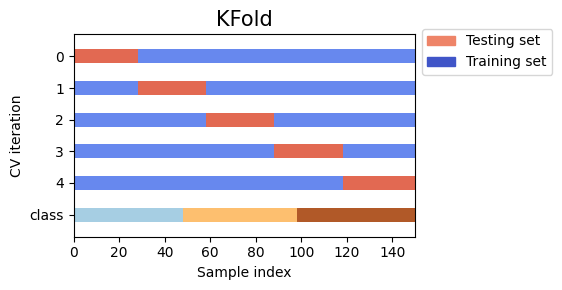

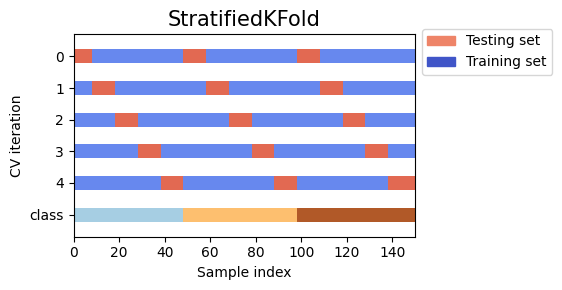

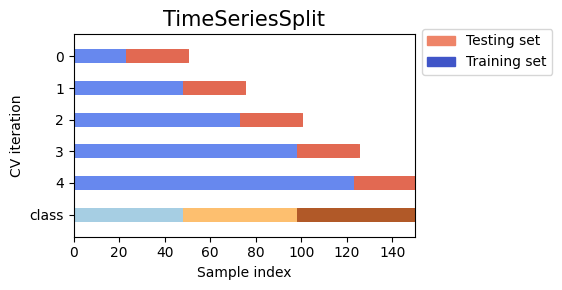

In [7]:
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit

splitters = [KFold, StratifiedKFold, TimeSeriesSplit]
n_splits = 5

from sklearn.datasets import load_iris
X, y = load_iris(return_X_y=True)

for splitter in splitters:
    current_splitter = splitter(n_splits=5)
    fig, ax = plt.subplots(figsize=(6, 3))
    plot_cv_indices(current_splitter, X, y, ax, n_splits)

    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
              ['Testing set', 'Training set'], loc=(1.02, .8))
    # Make the legend fit
    plt.tight_layout()
    fig.subplots_adjust(right=.7)
plt.show()

#### Ćwiczenie
Skopiuj, a następnie odpowiednio zmodyfikuj zawartość poprzedniej komórki, aby zwizualizować działanie podziału splittera `LeaveOneOut`.

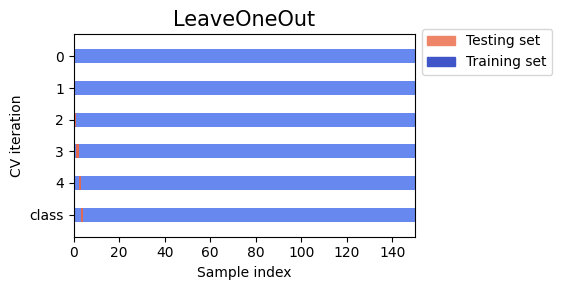

In [8]:
from sklearn.model_selection import LeaveOneOut

splitter = LeaveOneOut()

from sklearn.datasets import load_iris
X, y = load_iris(return_X_y=True)

fig, ax = plt.subplots(figsize=(6, 3))
plot_cv_indices(splitter, X, y, ax, n_splits=5)

ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
            ['Testing set', 'Training set'], loc=(1.02, .8))
# Make the legend fit
plt.tight_layout()
fig.subplots_adjust(right=.7)
plt.show()

#### Ćwiczenie

Sprawdź wartość dokładności modelu SVM w 5-krotnej walidacji krzyżowej podając splitter typu `StratifiedKFold` jako argument funkcji `cross_val_score`.

In [9]:
# Set up the StratifiedKFold splitter

stratified_KFold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print(cross_val_score(estimator=svm, X=X, y=y, cv=stratified_KFold).mean())

0.9866666666666667
